Ce notebook va être consacré au preprocessing du dataset et l'entrainement d'un premier modèle simple pour établir une baseline.

---

# Load

In [2]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

years = range(2019, 2023)

In [3]:
data = pd.DataFrame()

for year in years:
    path = os.path.join(base_path, str(year), file_name)
    year_csv = pd.read_csv(
            path,
            dtype=type_dict,
    )
    year_csv['Year'] = year
    data = pd.concat([
        data,
        year_csv
    ])

# Preprocessing

In [4]:
## TrackStatus ----------------------------------------------------------------

def trackStatus_to_binary(df):
    trackStatus = df['TrackStatus']
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

def process_trackStatus(df):
    trackStatuses = df.apply(trackStatus_to_binary, axis=1)
    return pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1).reset_index(drop=True)

## Missing Data ----------------------------------------------------------------

def process_missing_values(df):
    # TODO fill the missing values better
    df.fillna({
        'DistanceToDriverAhead': 0,
        'GapToLeader': 0,
        'IntervalToPositionAhead': 0,
    }, inplace=True)

    # drop all rows with missing laptime
    df.dropna(subset=['LapTime'], inplace=True)
    return df[df['LapNumber'] > 1]

## Datatypes -------------------------------------------------------------------

def process_datatypes(df):
    # boolean
    df['Green'] = df['Green'].astype('bool')
    df['Yellow'] = df['Yellow'].astype('bool')
    df['SC'] = df['SC'].astype('bool')
    df['Red'] = df['Red'].astype('bool')
    df['VSC'] = df['VSC'].astype('bool')
    df['SC_ending'] = df['SC_ending'].astype('bool')
    df['IsAccurate'] = df['IsAccurate'].astype('bool')
    df['Rainfall'] = df['Rainfall'].astype('bool')
    # category
    df['DriverNumber'] = df['DriverNumber'].astype('category')
    df['Team'] = df['Team'].astype('category')
    df['Compound'] = df['Compound'].astype('category')
    df['DriverAhead'] = df['DriverAhead'].astype('category')
    df['Track'] = df['Track'].astype('category')
    # float
    df['LapStartTime'] = df['LapStartTime'].astype('float32')
    df['LapTime'] = df['LapTime'].astype('float32')
    df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
    df['GapToLeader'] = df['GapToLeader'].astype('float32')
    df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
    df['AirTemp'] = df['AirTemp'].astype('float32')
    df['Humidity'] = df['Humidity'].astype('float32')
    df['Pressure'] = df['Pressure'].astype('float32')
    df['TrackTemp'] = df['TrackTemp'].astype('float32')
    df['WindDirection'] = df['WindDirection'].astype('float32')
    df['WindSpeed'] = df['WindSpeed'].astype('float32')
    # int
    df['LapNumber'] = df['LapNumber'].astype('uint8')
    df['TyreLife'] = df['TyreLife'].astype('uint8')
    df['Stint'] = df['Stint'].astype('uint8')
    df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
    df['Position'] = df['Position'].astype('uint8')
    df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
    df['TotalLaps'] = df['TotalLaps'].astype('uint8')
    return df

## Add target ------------------------------------------------------------------

def process_target(df):
    df['is_pitting'] = df['PitStatus'] == 'InLap'
    df['is_pitting'] = df['is_pitting'].astype('bool')
    return df

## Remove features -------------------------------------------------------------

def process_remove_features(df):
    df.drop(['LapStartTime', 'DriverNumber', 'Team', 'DriverAhead', 
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'PitStatus', 'IsAccurate'], axis=1, inplace=True)
    return df

## Feature encoding ------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder

def process_feature_encoding(df):
    categorical_features = ['Compound', 'Track']
    one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    one_hot_encoder.fit(df[categorical_features])
    one_hot_encoded = one_hot_encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))
    print("One hot : ", one_hot_encoded.shape)
    print("Data : ", df.shape)
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df, one_hot_encoder

In [5]:
def preprocess(df):
    print('Preprocessing data...', df.shape)
    df = process_trackStatus(df)
    print('TrackStatus processed...', df.shape)
    df = process_missing_values(df)
    print('Missing values processed...', df.shape)
    df = process_datatypes(df)
    print('Datatypes processed...', df.shape)
    df = process_target(df)
    print('Target processed...', df.shape)
    df = process_remove_features(df)
    print('Features removed...', df.shape)
    df, encoder = process_feature_encoding(df)
    print('Features encoded...', df.shape)
    return df, encoder

In [6]:
# see null values
#df[df.isna().any(axis=1)]


In [7]:
#print(df[df['Track_São Paulo'] == 1].shape)
#print(df[df['Track_Mexico City'] == 1].shape)
#print(df[df['Track_Spielberg'] == 1].shape)

In [8]:
#data.query('TotalLaps == 71').value_counts('Track')

In [9]:
df = data.copy()

In [10]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df, encoder = preprocess(train_df)
test_df, _ = preprocess(test_df)

Preprocessing data... (70276, 28)
TrackStatus processed... (70276, 33)
Missing values processed... (67709, 33)
Datatypes processed... (67709, 33)
Target processed... (67709, 34)
Features removed... (67709, 21)
One hot :  (67709, 40)
Data :  (67709, 21)


p:\Anaconda\envs\bsc\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Features encoded... (67709, 59)
Preprocessing data... (17569, 28)
TrackStatus processed... (17569, 33)
Missing values processed... (16921, 33)
Datatypes processed... (16921, 33)
Target processed... (16921, 34)
Features removed... (16921, 21)
One hot :  (16921, 40)
Data :  (16921, 21)
Features encoded... (16921, 59)


p:\Anaconda\envs\bsc\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

X_train = train_df.drop(['is_pitting'], axis=1)
y_train = train_df['is_pitting']

X_test = test_df.drop(['is_pitting'], axis=1)
y_test = test_df['is_pitting']

In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(65245, 58) (16299, 58) (65245,) (16299,)


# Evaluation  

In [14]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    
    

# Modelisation

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [16]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))


In [17]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [18]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

RandomForest


p:\Anaconda\envs\bsc\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 445  689  690  691  692  693  736  824  825  827  830  832  834  835
  837  838  839  840  842  843  844  845  846  847  850  852  853  855
  856  858  859  862  864  950  951  952  953  960  962  990  991  992
  993  994  995  996  997 1002 1003 1005 1006 1007 1009 1010 1011 1012
 1013 1014 1015 1016 1017 1018 1019 1021 1022 1023 1025 1026 1027 1029
 1030 1039 1067 1076 1087 1104 1105 1106 1107 1108 1109 1113 1114 1115
 1116 1117 1118 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130
 1131 1132 1133 1134 1136 1137 1138 1140 1141 1142 1143 1144 1145 1146
 1147 1148 1149 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160
 1161 1162 1163 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1175
 1176 1177 1178 1179 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189
 1190 1191 1192 1193 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203
 1204 1205 1206 1207 1209 1210 

[[15748    59]
 [  311   181]]
              precision    recall  f1-score   support

       False       0.98      1.00      0.99     15807
        True       0.75      0.37      0.49       492

    accuracy                           0.98     16299
   macro avg       0.87      0.68      0.74     16299
weighted avg       0.97      0.98      0.97     16299



p:\Anaconda\envs\bsc\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  15   73  130  186  241  295  348  400  445  451  501  550  598  645
  689  690  691  692  693  736  773  780  823  824  825  826  827  828
  829  830  831  832  833  834  835  836  837  838  839  840  841  842
  843  844  845  846  847  848  849  850  851  852  853  854  855  856
  857  858  859  860  861  862  863  864  865  872  874  879  882  895
  898  902  913  915  918  919  920  923  925  936  937  940  941  942
  943  947  950  951  952  953  960  962  990  991  992  993  994  995
  996  997 1002 1003 1005 1006 1007 1009 1010 1011 1012 1013 1014 1015
 1016 1017 1018 1019 1021 1022 1023 1025 1026 1027 1029 1030 1039 1067
 1076 1077 1087 1104 1105 1106 1107 1108 1109 1113 1114 1115 1116 1117
 1118 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132
 1133 1134 1135 1136 1137 1138 1140 1141 1142 1143 1144 1145 1146 1147
 1148 1149 1150 1151 1152 1153 

AdaBoost


p:\Anaconda\envs\bsc\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 445  689  690  691  692  693  736  824  825  827  830  832  834  835
  837  838  839  840  842  843  844  845  846  847  850  852  853  855
  856  858  859  862  864  950  951  952  953  960  962  990  991  992
  993  994  995  996  997 1002 1003 1005 1006 1007 1009 1010 1011 1012
 1013 1014 1015 1016 1017 1018 1019 1021 1022 1023 1025 1026 1027 1029
 1030 1039 1067 1076 1087 1104 1105 1106 1107 1108 1109 1113 1114 1115
 1116 1117 1118 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130
 1131 1132 1133 1134 1136 1137 1138 1140 1141 1142 1143 1144 1145 1146
 1147 1148 1149 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160
 1161 1162 1163 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1175
 1176 1177 1178 1179 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189
 1190 1191 1192 1193 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203
 1204 1205 1206 1207 1209 1210 

[[15789    18]
 [  469    23]]
              precision    recall  f1-score   support

       False       0.97      1.00      0.98     15807
        True       0.56      0.05      0.09       492

    accuracy                           0.97     16299
   macro avg       0.77      0.52      0.54     16299
weighted avg       0.96      0.97      0.96     16299



p:\Anaconda\envs\bsc\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  15   73  130  186  241  295  348  400  445  451  501  550  598  645
  689  690  691  692  693  736  773  780  823  824  825  826  827  828
  829  830  831  832  833  834  835  836  837  838  839  840  841  842
  843  844  845  846  847  848  849  850  851  852  853  854  855  856
  857  858  859  860  861  862  863  864  865  872  874  879  882  895
  898  902  913  915  918  919  920  923  925  936  937  940  941  942
  943  947  950  951  952  953  960  962  990  991  992  993  994  995
  996  997 1002 1003 1005 1006 1007 1009 1010 1011 1012 1013 1014 1015
 1016 1017 1018 1019 1021 1022 1023 1025 1026 1027 1029 1030 1039 1067
 1076 1077 1087 1104 1105 1106 1107 1108 1109 1113 1114 1115 1116 1117
 1118 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132
 1133 1134 1135 1136 1137 1138 1140 1141 1142 1143 1144 1145 1146 1147
 1148 1149 1150 1151 1152 1153 

SVM


p:\Anaconda\envs\bsc\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 445  689  690  691  692  693  736  824  825  827  830  832  834  835
  837  838  839  840  842  843  844  845  846  847  850  852  853  855
  856  858  859  862  864  950  951  952  953  960  962  990  991  992
  993  994  995  996  997 1002 1003 1005 1006 1007 1009 1010 1011 1012
 1013 1014 1015 1016 1017 1018 1019 1021 1022 1023 1025 1026 1027 1029
 1030 1039 1067 1076 1087 1104 1105 1106 1107 1108 1109 1113 1114 1115
 1116 1117 1118 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130
 1131 1132 1133 1134 1136 1137 1138 1140 1141 1142 1143 1144 1145 1146
 1147 1148 1149 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160
 1161 1162 1163 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1175
 1176 1177 1178 1179 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189
 1190 1191 1192 1193 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203
 1204 1205 1206 1207 1209 1210 

[[15799     8]
 [  468    24]]
              precision    recall  f1-score   support

       False       0.97      1.00      0.99     15807
        True       0.75      0.05      0.09       492

    accuracy                           0.97     16299
   macro avg       0.86      0.52      0.54     16299
weighted avg       0.96      0.97      0.96     16299



p:\Anaconda\envs\bsc\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  15   73  130  186  241  295  348  400  445  451  501  550  598  645
  689  690  691  692  693  736  773  780  823  824  825  826  827  828
  829  830  831  832  833  834  835  836  837  838  839  840  841  842
  843  844  845  846  847  848  849  850  851  852  853  854  855  856
  857  858  859  860  861  862  863  864  865  872  874  879  882  895
  898  902  913  915  918  919  920  923  925  936  937  940  941  942
  943  947  950  951  952  953  960  962  990  991  992  993  994  995
  996  997 1002 1003 1005 1006 1007 1009 1010 1011 1012 1013 1014 1015
 1016 1017 1018 1019 1021 1022 1023 1025 1026 1027 1029 1030 1039 1067
 1076 1077 1087 1104 1105 1106 1107 1108 1109 1113 1114 1115 1116 1117
 1118 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132
 1133 1134 1135 1136 1137 1138 1140 1141 1142 1143 1144 1145 1146 1147
 1148 1149 1150 1151 1152 1153 

KNN


p:\Anaconda\envs\bsc\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 445  689  690  691  692  693  736  824  825  827  830  832  834  835
  837  838  839  840  842  843  844  845  846  847  850  852  853  855
  856  858  859  862  864  950  951  952  953  960  962  990  991  992
  993  994  995  996  997 1002 1003 1005 1006 1007 1009 1010 1011 1012
 1013 1014 1015 1016 1017 1018 1019 1021 1022 1023 1025 1026 1027 1029
 1030 1039 1067 1076 1087 1104 1105 1106 1107 1108 1109 1113 1114 1115
 1116 1117 1118 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130
 1131 1132 1133 1134 1136 1137 1138 1140 1141 1142 1143 1144 1145 1146
 1147 1148 1149 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160
 1161 1162 1163 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1175
 1176 1177 1178 1179 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189
 1190 1191 1192 1193 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203
 1204 1205 1206 1207 1209 1210 

[[15749    58]
 [  339   153]]
              precision    recall  f1-score   support

       False       0.98      1.00      0.99     15807
        True       0.73      0.31      0.44       492

    accuracy                           0.98     16299
   macro avg       0.85      0.65      0.71     16299
weighted avg       0.97      0.98      0.97     16299



p:\Anaconda\envs\bsc\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  15   73  130  186  241  295  348  400  445  451  501  550  598  645
  689  690  691  692  693  736  773  780  823  824  825  826  827  828
  829  830  831  832  833  834  835  836  837  838  839  840  841  842
  843  844  845  846  847  848  849  850  851  852  853  854  855  856
  857  858  859  860  861  862  863  864  865  872  874  879  882  895
  898  902  913  915  918  919  920  923  925  936  937  940  941  942
  943  947  950  951  952  953  960  962  990  991  992  993  994  995
  996  997 1002 1003 1005 1006 1007 1009 1010 1011 1012 1013 1014 1015
 1016 1017 1018 1019 1021 1022 1023 1025 1026 1027 1029 1030 1039 1067
 1076 1077 1087 1104 1105 1106 1107 1108 1109 1113 1114 1115 1116 1117
 1118 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132
 1133 1134 1135 1136 1137 1138 1140 1141 1142 1143 1144 1145 1146 1147
 1148 1149 1150 1151 1152 1153 

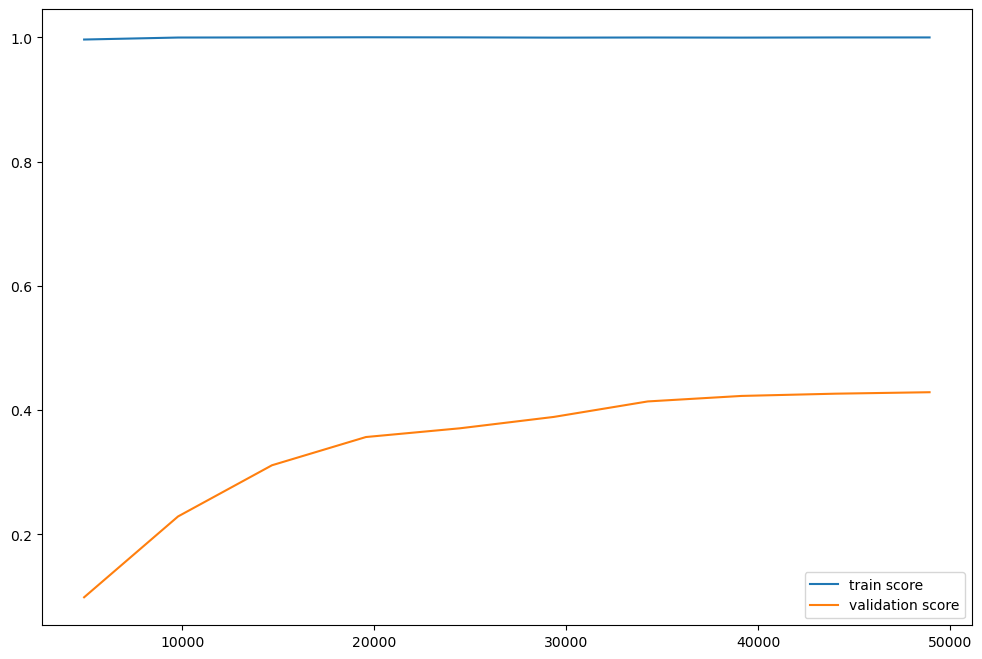

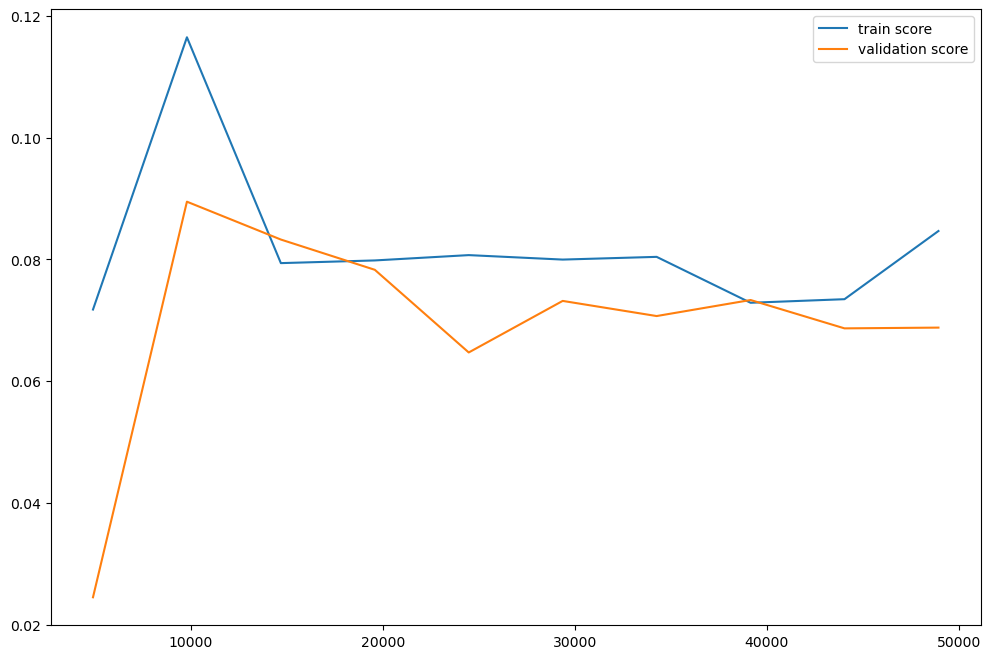

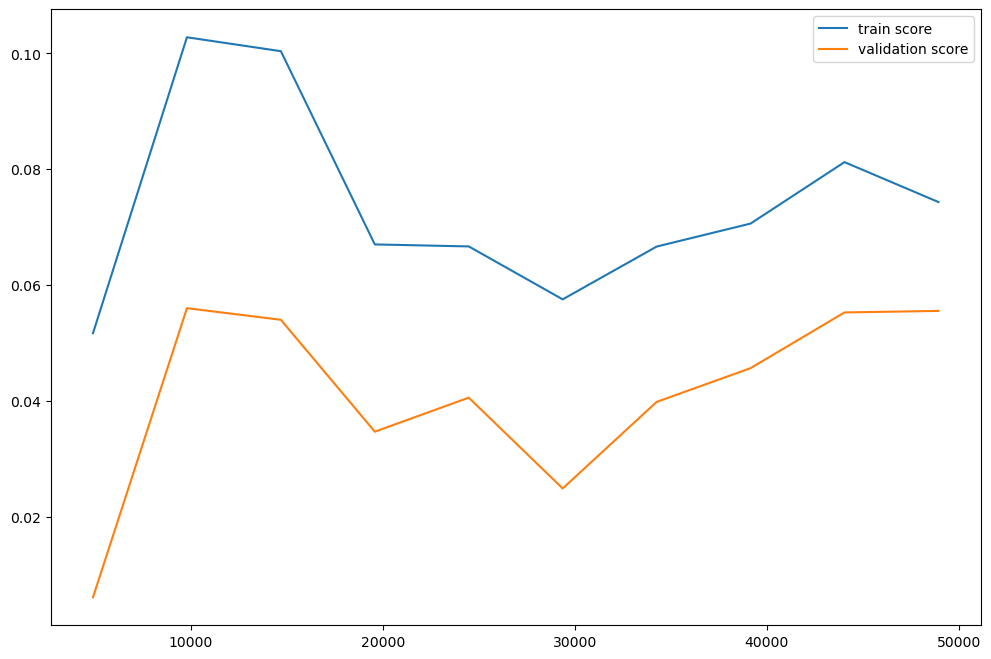

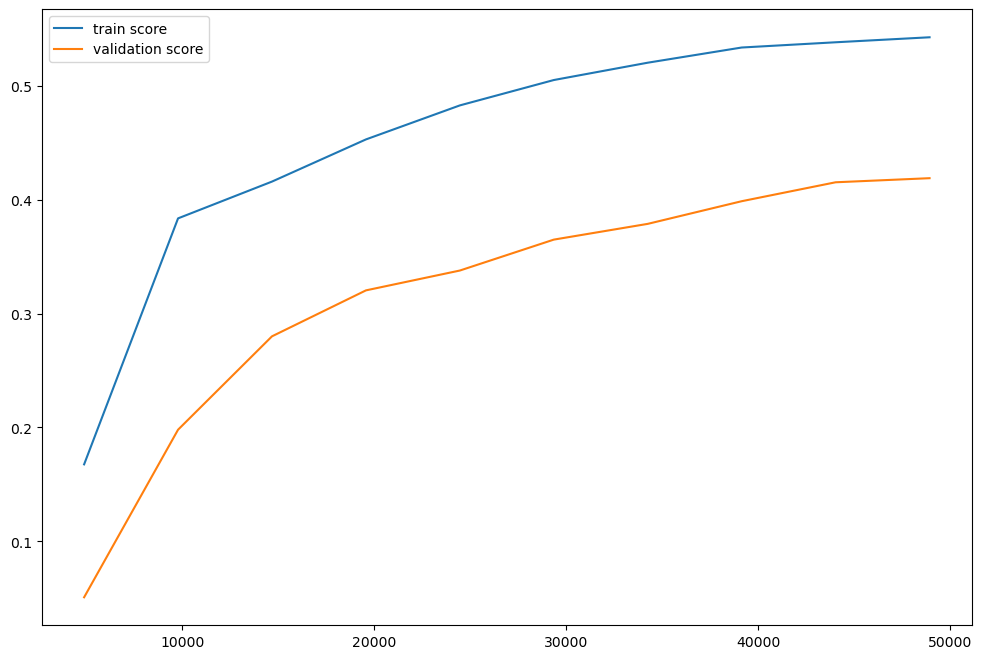

In [19]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)



In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {'randomforestclassifier__max_depth': [3, 5, 7, 9, 11, 13],
                'randomforestclassifier__max_features': [0.3, 0.5, 0.7, 0.9, 1],
                'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
grid = GridSearchCV(RandomForest, param_grid, cv=4, scoring='f1', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_test, y_test))

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


MemoryError: Unable to allocate 14.9 MiB for an array with shape (40, 48934) and data type float64

In [23]:
model = RandomForestClassifier(random_state=0,
                               class_weight='balanced_subsample',
                               n_estimators=1000,
                               max_depth=10,
                               min_samples_split=2,
                               min_samples_leaf=1,)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

[[13802  2005]
 [  148   344]]
              precision    recall  f1-score   support

       False       0.99      0.87      0.93     15807
        True       0.15      0.70      0.24       492

    accuracy                           0.87     16299
   macro avg       0.57      0.79      0.58     16299
weighted avg       0.96      0.87      0.91     16299



# Test

In [24]:
# Load test data
test_data = pd.read_csv('data/2023/bahrain_grand_prix.csv'
                        , dtype=type_dict)

In [30]:
test_df_44 = test_data.query('DriverNumber == "44"').copy()
test_df_44['Year'] = 2023
test_df_44.head()

,LapStartTime,LapNumber,LapTime,DriverNumber,Team,Compound,TyreLife,TrackStatus,Stint,DistanceToDriverAhead,DriverAhead,PitStatus,IsAccurate,NumberOfPitStops,Position,GapToLeader,IntervalToPositionAhead,LapsToLeader,Track,TotalLaps,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Year
16,3756.652100,1,NaN,44,Mercedes,SOFT,4,2,1,NaN,NaN,OutLap,False,0,5,3.269,0.629,0,Sakhir,57,27.299999,22.0,1016.700012,False,31.299999,0.0,0.6,2023
24,3859.210938,2,99.166000,44,Mercedes,SOFT,5,2,1,50.203609,55,NoPit,True,0,5,4.480,0.864,0,Sakhir,57,27.299999,22.0,1016.700012,False,31.200001,190.0,0.6,2023
44,3958.376953,3,99.220001,44,Mercedes,SOFT,6,1,1,62.451946,55,NoPit,True,0,5,5.675,1.040,0,Sakhir,57,27.299999,22.0,1016.900024,False,31.100000,197.0,0.6,2023
64,4057.596924,4,99.197998,44,Mercedes,SOFT,7,1,1,81.827499,55,NoPit,True,0,5,6.897,1.253,0,Sakhir,57,27.299999,22.0,1016.700012,False,31.200001,170.0,0.6,2023
84,4156.794922,5,99.334999,44,Mercedes,SOFT,8,1,1,100.092499,55,NoPit,True,0,5,8.197,1.460,0,Sakhir,57,27.200001,22.0,1016.900024,False,31.100000,236.0,0.8,2023


In [26]:
def process_feature_encoding_new(df, encoder):
    categorical_features = ['Compound', 'Track']
    one_hot_encoded = encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df

def preprocess_new_data(df, encoder):
    print('Preprocessing data...', df.shape)
    df = process_trackStatus(df)
    print('TrackStatus processed...', df.shape)
    df = process_missing_values(df)
    print('Missing values processed...', df.shape)
    df = process_datatypes(df)
    print('Datatypes processed...', df.shape)
    df = process_target(df)
    print('Target processed...', df.shape)
    df = process_remove_features(df)
    print('Features removed...', df.shape)
    df = process_feature_encoding_new(df, encoder)
    print('Features encoded...', df.shape)
    return df

In [31]:
test_df_44 = preprocess_new_data(test_df_44, encoder)

test_df_44.dropna(inplace=True)

test_df_44.head()

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (56, 34)
Features removed... (56, 21)
Features encoded... (56, 59)


,LapNumber,LapTime,TyreLife,Stint,DistanceToDriverAhead,NumberOfPitStops,Position,GapToLeader,IntervalToPositionAhead,LapsToLeader,TotalLaps,Year,Green,Yellow,SC,Red,VSC,SC_ending,is_pitting,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET,Track_Abu Dhabi,Track_Al Daayen,Track_Austin,Track_Baku,Track_Barcelona,Track_Budapest,Track_Hockenheim,Track_Imola,Track_Istanbul,Track_Jeddah,Track_Le Castellet,Track_Marina Bay,Track_Melbourne,Track_Mexico City,Track_Miami,Track_Monaco,Track_Monte-Carlo,Track_Montmeló,Track_Montreal,Track_Montréal,Track_Monza,Track_Mugello,Track_Nürburg,Track_Portimão,Track_Sakhir,Track_Shanghai,Track_Silverstone,Track_Sochi,Track_Spa,Track_Spa-Francorchamps,Track_Spielberg,Track_Suzuka,Track_São Paulo,Track_Yas Island,Track_Zandvoort
1,2,99.166000,5,1,50.203609,0,5,4.480,0.864,0,57,2023,False,True,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,99.220001,6,1,62.451946,0,5,5.675,1.040,0,57,2023,True,False,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,99.197998,7,1,81.827499,0,5,6.897,1.253,0,57,2023,True,False,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,99.334999,8,1,100.092499,0,5,8.197,1.460,0,57,2023,True,False,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,99.755997,9,1,106.815834,0,5,9.967,1.742,0,57,2023,True,False,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
x_test_44 = test_df_44.drop('is_pitting', axis=1)
y_test_44 = test_df_44['is_pitting']

print(x_test_44.shape, y_test_44.shape)

(55, 58) (55,)


In [33]:
ypred_44 = model.predict(x_test_44)

print(confusion_matrix(y_test_44, ypred_44))
print(classification_report(y_test_44, ypred_44))

[[49  4]
 [ 0  2]]
              precision    recall  f1-score   support

       False       1.00      0.92      0.96        53
        True       0.33      1.00      0.50         2

    accuracy                           0.93        55
   macro avg       0.67      0.96      0.73        55
weighted avg       0.98      0.93      0.94        55



In [50]:
probability_pit = model.predict_proba(x_test_44)[:,1]

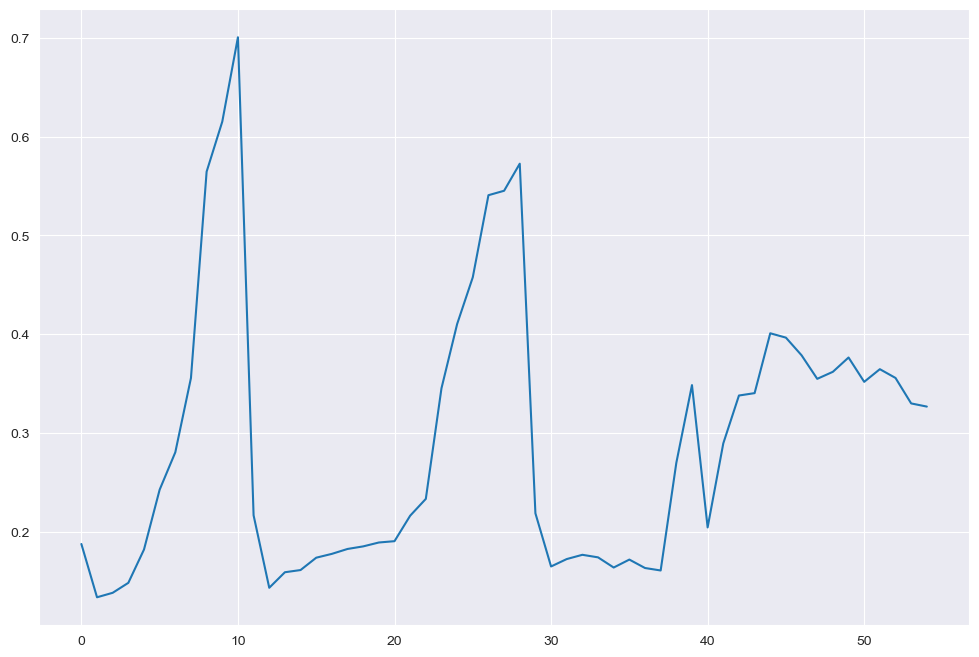

In [51]:
plt.figure(figsize=(12, 8))
plt.plot(probability_pit)

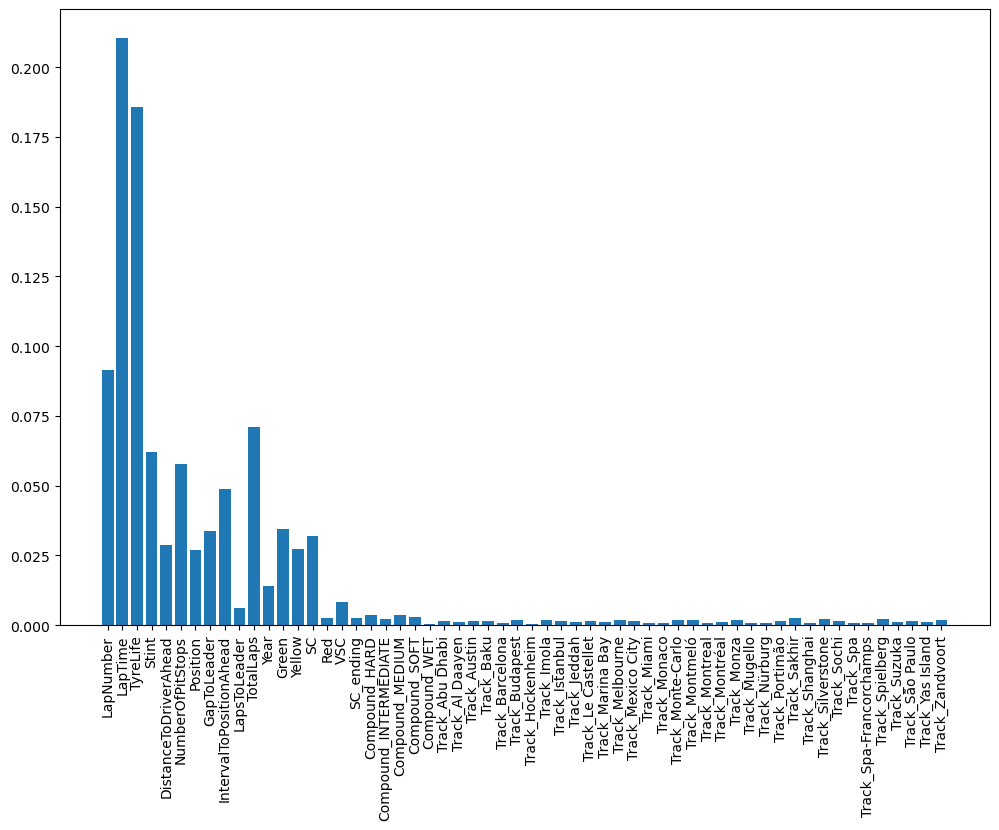

In [35]:
plt.figure(figsize=(12, 8))
plt.bar(x_test_44.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [70]:
import matplotlib.patches as mpatches
def plot_predictions_by_lapNumber(x_test, y_test, ypred, proba, title=None):
    sns.set_style('darkgrid')
    fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
    sns.scatterplot(x=x_test['LapNumber'], y=0, hue=y_test, palette='Set1', marker='o', ax=axes[0], legend=False)
    sns.scatterplot(x=x_test['LapNumber'], y=0.5, hue=ypred, palette='Set1', marker='o', ax=axes[0], legend=False)
    sns.scatterplot(x=x_test['LapNumber'], y=proba, palette='plasma', hue=proba, marker='X', legend=False, ax=axes[1])
    axes[0].set_yticks([0, 0.5], ['Actual', 'Predicted'])
    axes[0].set_ylim(-0.5, 1)
    plt.xlabel('Lap Number')
    plt.xticks(np.arange(0, x_test['TotalLaps'].max(), 5))
    plt.ylim(0, 1)
    patch = mpatches.Patch(color='cornflowerblue', label='Pit stop')
    patch2 = mpatches.Patch(color='crimson', label='No pit stop')
    axes[0].legend(handles=[patch, patch2])
    if title:
        axes[0].set_title(title)
    plt.show()

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (56, 34)
Features removed... (56, 21)
Features encoded... (56, 59)


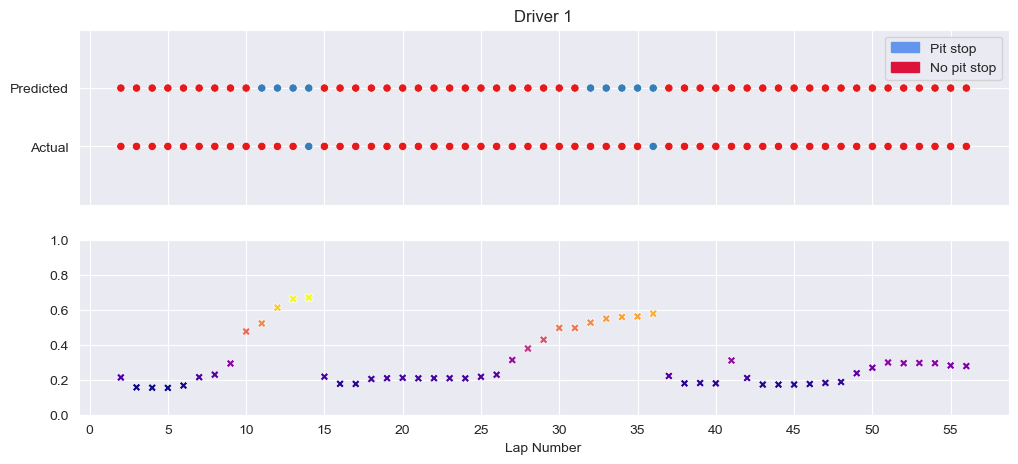

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (56, 34)
Features removed... (56, 21)
Features encoded... (56, 59)


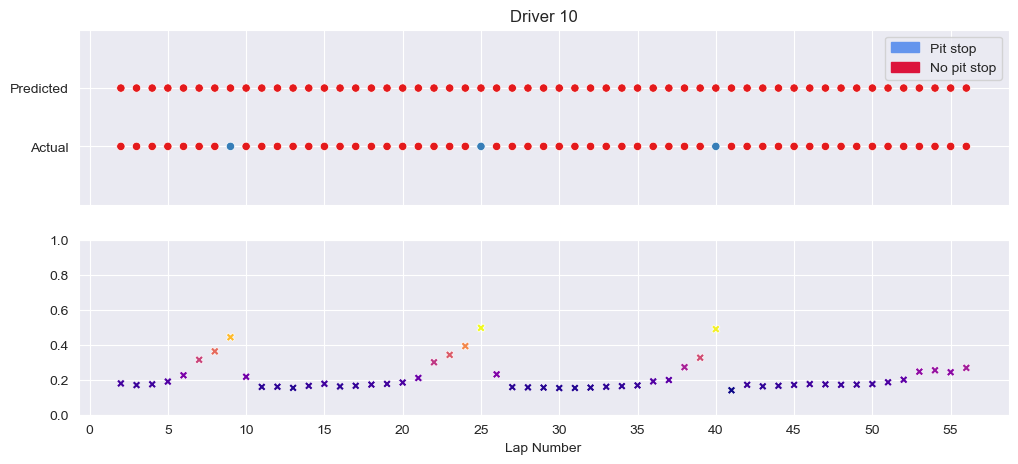

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (56, 34)
Features removed... (56, 21)
Features encoded... (56, 59)


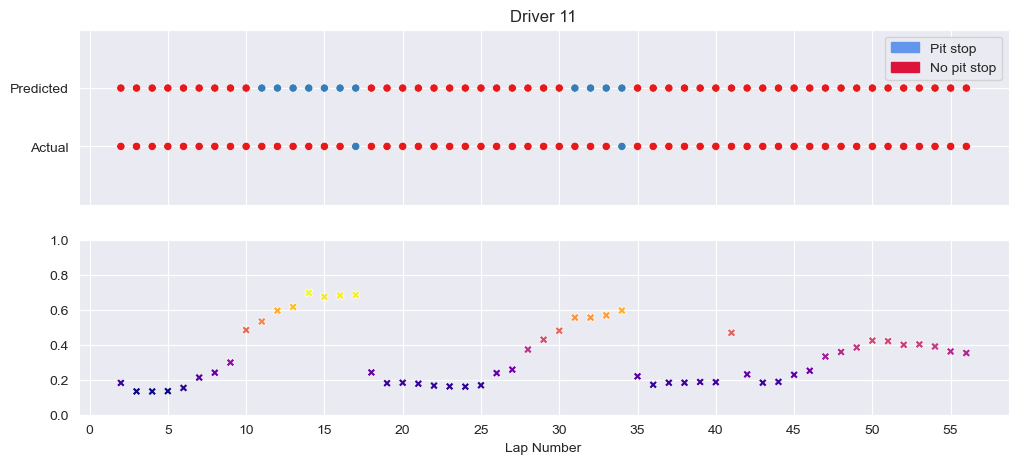

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (55, 33)
Datatypes processed... (55, 33)
Target processed... (55, 34)
Features removed... (55, 21)
Features encoded... (55, 59)


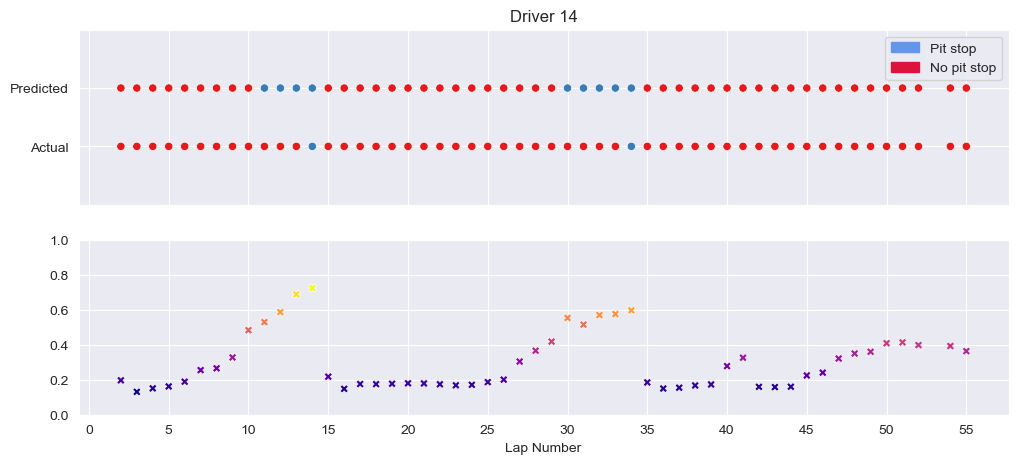

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (56, 34)
Features removed... (56, 21)
Features encoded... (56, 59)


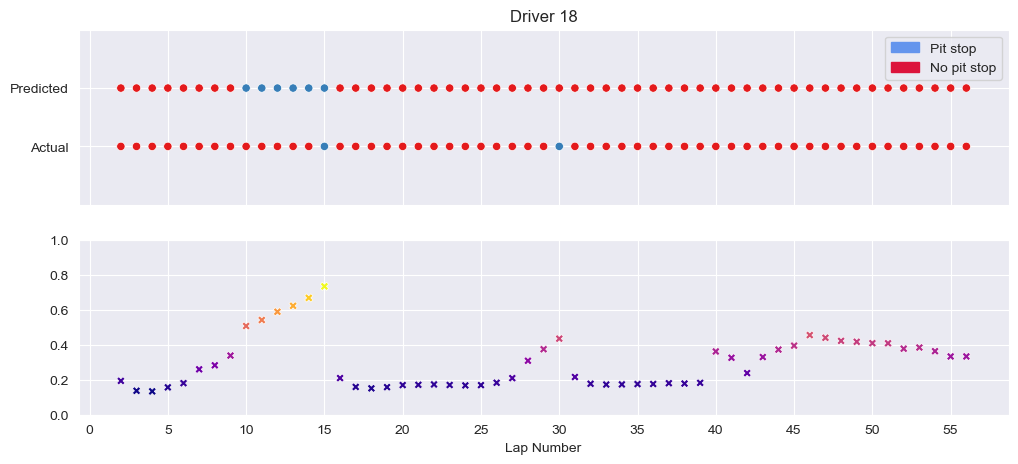

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (56, 34)
Features removed... (56, 21)
Features encoded... (56, 59)


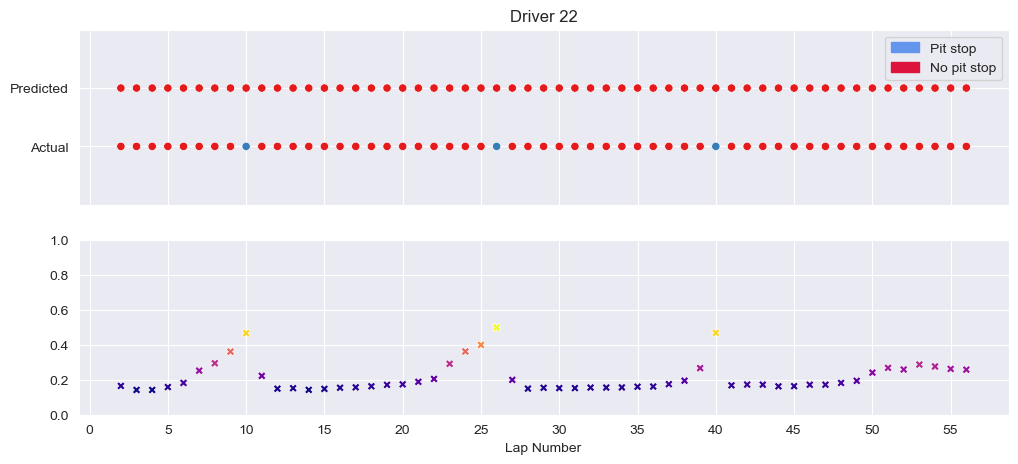

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (56, 34)
Features removed... (56, 21)
Features encoded... (56, 59)


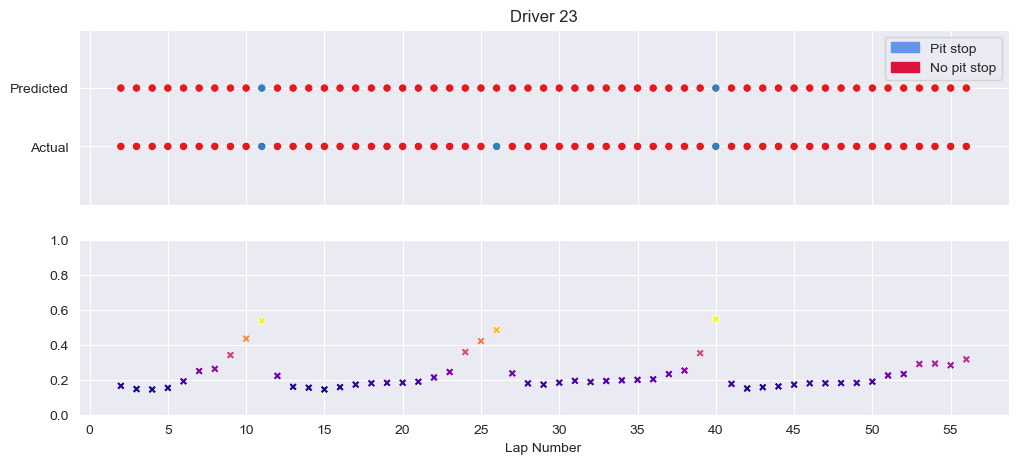

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (56, 34)
Features removed... (56, 21)
Features encoded... (56, 59)


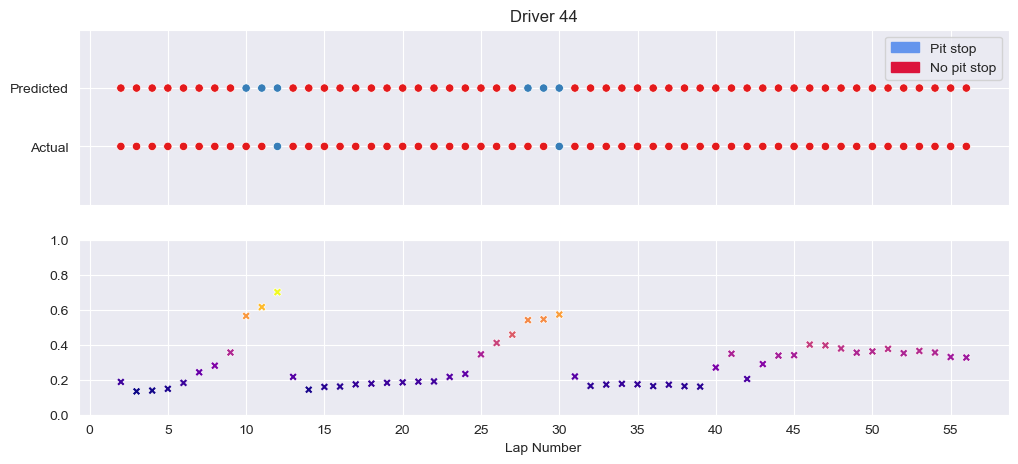

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (56, 34)
Features removed... (56, 21)
Features encoded... (56, 59)


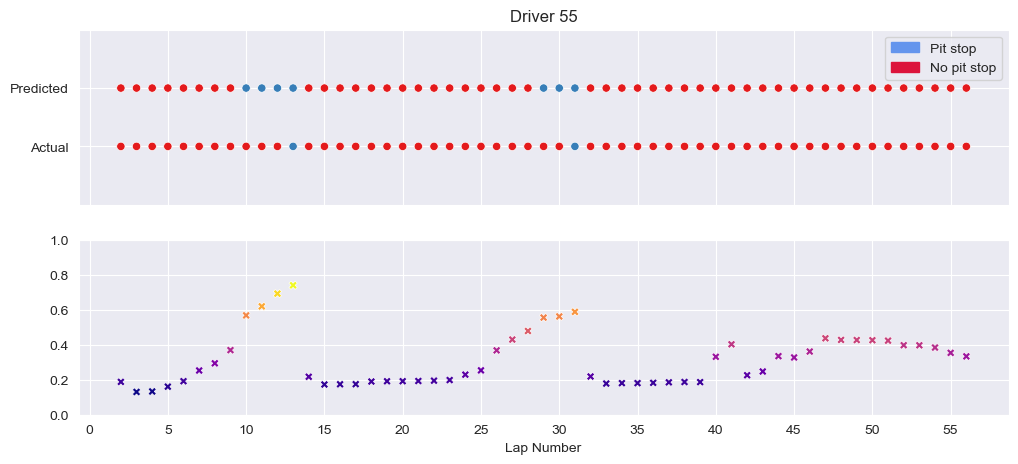

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (56, 34)
Features removed... (56, 21)
Features encoded... (56, 59)


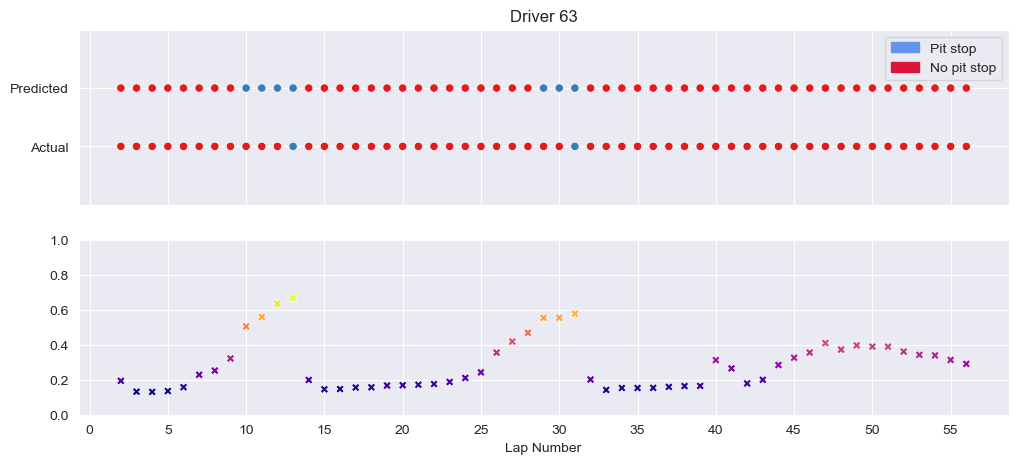

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (56, 34)
Features removed... (56, 21)
Features encoded... (56, 59)


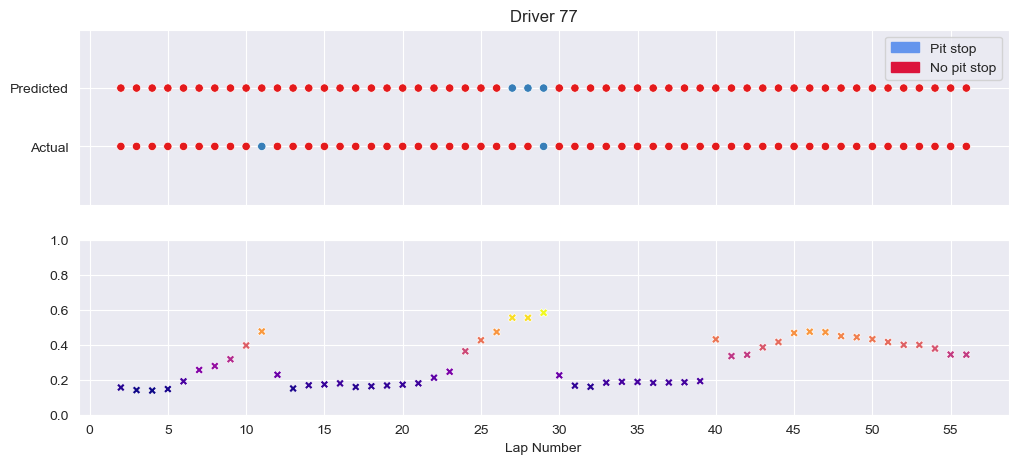

In [71]:
test_data['Year'] = 2023
test_drivers = test_data.groupby('DriverNumber').agg({'LapNumber': 'max', 'TotalLaps': 'max'}).query('LapNumber == TotalLaps').index

for driver in test_drivers:
    test_df = test_data.query(f'DriverNumber == "{driver}"').copy()
    test_df = preprocess_new_data(test_df, encoder)
    test_df.dropna(inplace=True)
    x_test = test_df.drop('is_pitting', axis=1)
    y_test = test_df['is_pitting']
    ypred = model.predict(x_test)
    proba = model.predict_proba(x_test)[:,1]
    plot_predictions_by_lapNumber(x_test, y_test, ypred, proba, title=f'Driver {driver}')